# Generic Braille Cell Encoding Classifier

## DenseNet121 - Balanced Dataset

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import DenseNet121

In [2]:
from collections import Counter
import plotly.express as px
import os
from glob import glob
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

## Dataset

### Dataset Expansion
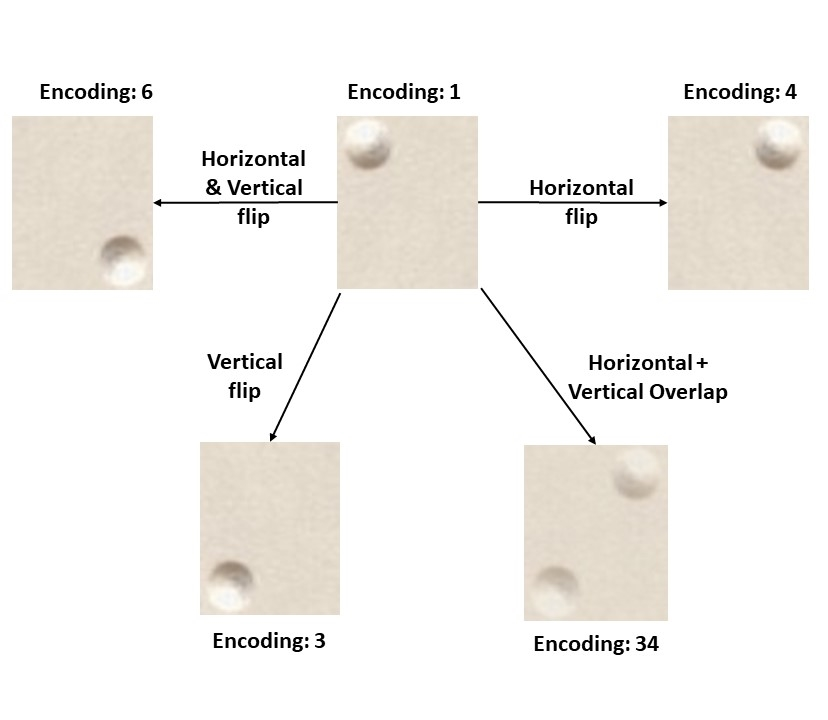

In [ ]:
srcfolder = "123"
tgtfolder = "123456"
flipdir = {"h":1, "v":0, "b":-1, "o":2}
flipcode = flipdir["o"]

i=0
for tgt in os.listdir("dataset/" + srcfolder):
    if not tgt == ".DS_Store":
        for folder in os.listdir("dataset/" + srcfolder + "/" + tgt):
                if not folder == ".DS_Store":
                    os.makedirs("dataset/" + tgtfolder + "/" + tgt + "/" + folder)  
                    for filename in os.listdir("dataset/" + srcfolder + "/" + tgt + "/" + folder):
                        if not filename == ".DS_Store":
                            i+=1
                            print(i, end=",")
                            os.getcwd()
                            # Reading an image in default mode
                            src = cv2.imread("dataset/" + srcfolder + "/" + tgt + "/" + folder + "/"+ filename)

                            if flipcode == 2:
                                image = cv2.addWeighted(cv2.flip(src, flipdir["h"]), 0.5, cv2.flip(src, flipdir["v"]), 0.5, 0)
                            else:
                                # Using cv2.flip() method
                                # Use Flip code 0 to flip vertically, 1 to flip hortizontally, -1 for both
                                image = cv2.flip(src, flipcode)
                        
                            # Using cv2.imwrite() method
                            # Saving the image
                            cv2.imwrite("dataset/" + tgtfolder + "/" + tgt + "/" + folder + "/" + filename, image)

In [3]:
%pwd

'D:\\work\\nive\\SSN-College-Of-Engineering\\all-SEMESTERS\\SEM8\\UCS1818 Project Work\\Review3\\Code\\Classifier'

In [4]:
ImagePATH = f"dataset/"
print(ImagePATH)

dataset/


In [5]:
categories = glob(ImagePATH+"*")
print(categories)
print(f"\nNumber of categories: {len(categories)}")

['dataset\\0', 'dataset\\1', 'dataset\\12', 'dataset\\123', 'dataset\\1234', 'dataset\\12345', 'dataset\\123456', 'dataset\\12346', 'dataset\\1235', 'dataset\\12356', 'dataset\\1236', 'dataset\\124', 'dataset\\1245', 'dataset\\12456', 'dataset\\1246', 'dataset\\125', 'dataset\\1256', 'dataset\\126', 'dataset\\13', 'dataset\\134', 'dataset\\1345', 'dataset\\13456', 'dataset\\1346', 'dataset\\135', 'dataset\\1356', 'dataset\\136', 'dataset\\14', 'dataset\\145', 'dataset\\1456', 'dataset\\146', 'dataset\\15', 'dataset\\156', 'dataset\\16', 'dataset\\2', 'dataset\\23', 'dataset\\234', 'dataset\\2345', 'dataset\\23456', 'dataset\\2346', 'dataset\\235', 'dataset\\2356', 'dataset\\236', 'dataset\\24', 'dataset\\245', 'dataset\\2456', 'dataset\\246', 'dataset\\25', 'dataset\\256', 'dataset\\26', 'dataset\\3', 'dataset\\34', 'dataset\\345', 'dataset\\3456', 'dataset\\346', 'dataset\\35', 'dataset\\356', 'dataset\\36', 'dataset\\4', 'dataset\\45', 'dataset\\456', 'dataset\\46', 'dataset\\5', 'da

In [6]:
filedf = pd.DataFrame()
for cat in categories:
    files = glob(cat+"/*")
    tempdf = pd.DataFrame({'filepath':files,'category':cat.split("\\")[-1]})
    filedf = pd.concat([filedf,tempdf])
# len(np.unique(filedf.category))

In [7]:
gby_cnt = filedf.groupby("category").aggregate('count').rename(columns = {'filepath':'cnt'}).reset_index().sort_values(by='cnt',ascending=False)
print(gby_cnt)
print(np.array(gby_cnt['category']))
print(np.array(gby_cnt['cnt']))

   category  cnt
0         0  750
1         1  750
34       23  750
35      234  750
36     2345  750
..      ...  ...
26       14  750
27      145  750
28     1456  750
29      146  750
63        6  750

[64 rows x 2 columns]
['0' '1' '23' '234' '2345' '23456' '2346' '235' '2356' '236' '24' '245'
 '2456' '246' '25' '256' '26' '3' '34' '345' '3456' '346' '35' '356' '36'
 '4' '45' '456' '46' '5' '56' '2' '16' '156' '125' '12' '123' '1234'
 '12345' '123456' '12346' '1235' '12356' '1236' '124' '1245' '12456'
 '1246' '1256' '15' '126' '13' '134' '1345' '13456' '1346' '135' '1356'
 '136' '14' '145' '1456' '146' '6']
[750 750 750 750 750 750 750 750 750 750 750 750 750 750 750 750 750 750
 750 750 750 750 750 750 750 750 750 750 750 750 750 750 750 750 750 750
 750 750 750 750 750 750 750 750 750 750 750 750 750 750 750 750 750 750
 750 750 750 750 750 750 750 750 750 750]


In [8]:
braille_cell_encoding_class= list(gby_cnt['category'])
data_dir = 'dataset'
train_dir = os.path.join(data_dir)

In [9]:
train_data = []
for braille_cell_id, sp in enumerate(braille_cell_encoding_class):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), braille_cell_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'Braille Cell ID','Braille Cell Encoding'])
train[35:50]

,File,Braille Cell ID,Braille Cell Encoding
35,0/0-125-Uploaded-set2.jpg,0,0
36,0/0-126-Uploaded-set2.jpg,0,0
37,0/0-127-Uploaded-set2.jpg,0,0
38,0/0-128-Uploaded-set2.jpg,0,0
39,0/0-129-Uploaded-set2.jpg,0,0
40,0/0-13-Uploaded-set1.jpg,0,0
41,0/0-13-Uploaded-set2.jpg,0,0
42,0/0-130-Uploaded-set2.jpg,0,0
43,0/0-131-Uploaded-set2.jpg,0,0
44,0/0-132-Uploaded-set2.jpg,0,0


## Randomize the order of training set

In [10]:
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,Braille Cell ID,Braille Cell Encoding
0,1236/1236-6-Uploaded-set2.jpg,43,1236
1,134/134-52-Uploaded-set3.jpg,52,134
2,136/136-111-Uploaded-set3.jpg,58,136
3,234/234-94-Uploaded-set1.jpg,3,234
4,2345/2345-34-Uploaded-set1.jpg,4,2345


## Data Exploration

### Data before balancing

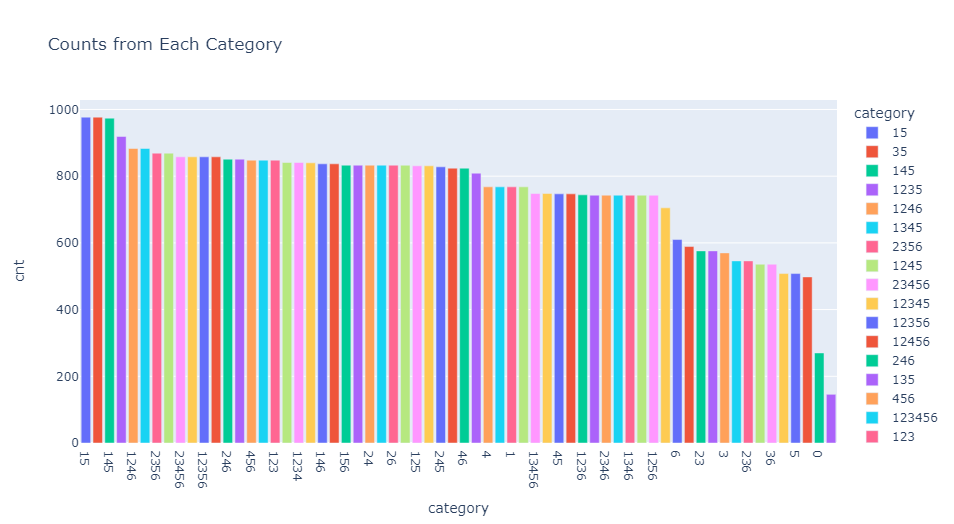

### Data after balancing
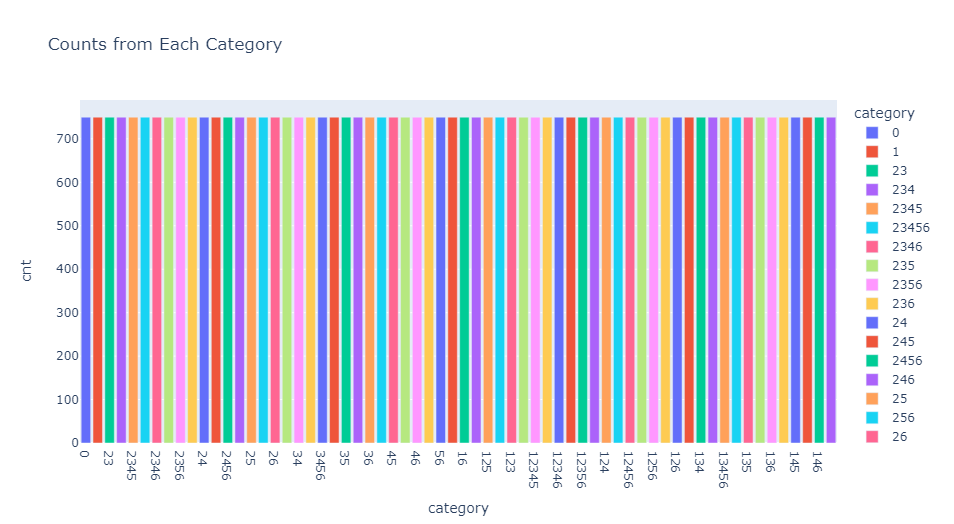

## Display images of Braille Encoding Classes

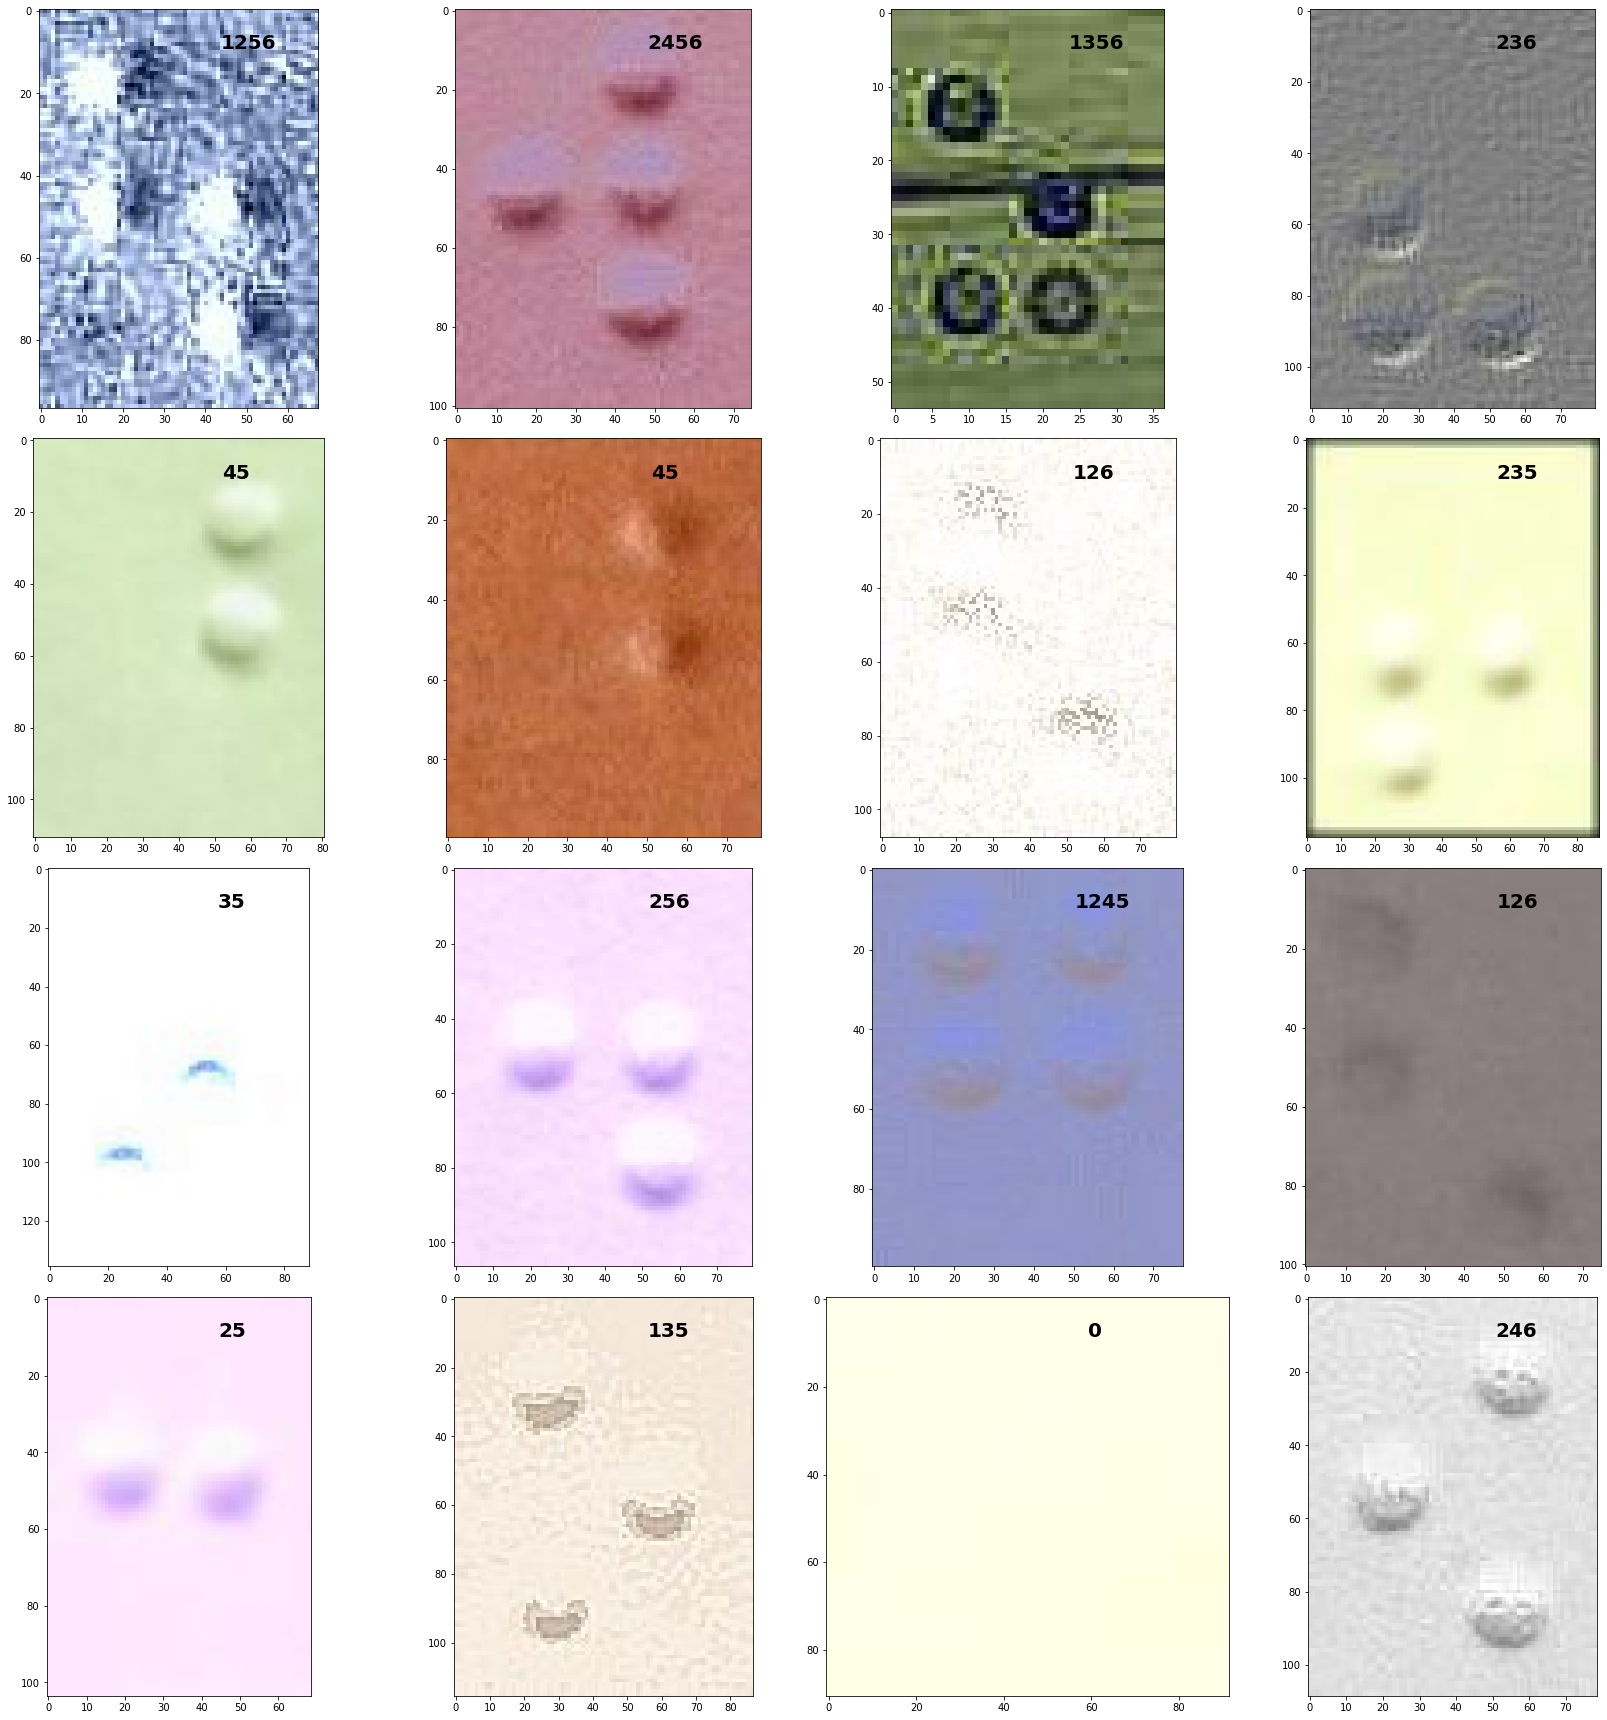

In [12]:
# Image manipulations
from PIL import Image
plt.figure(figsize=(24, 24))

for i in range(16):
    path = train.sample(1)['File'].values[0]
    path = "dataset/" + path
    category = path.split("/")[1]
    ex_img = Image.open(path)
    ax = plt.subplot(4, 4, i + 1)
    ax.annotate(category, xy=(0.65, 0.9), xycoords="axes fraction",weight='bold',size=20)
    ax.imshow(ex_img)

plt.tight_layout()

## Image Read and Resize Function

In [13]:
IMAGE_SIZE = 64
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

## Training Images

In [14]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

48000it [00:30, 1582.07it/s]


Train Shape: (48000, 64, 64, 3)


## Converting Labels to Categorical

In [15]:
Y_train = train['Braille Cell ID'].values
Y_train = to_categorical(Y_train, num_classes=64)

In [16]:
print(Y_train.shape)

(48000, 64)


## Train Test Splitting

In [17]:
# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

In [18]:
print(f'X_train:',X_train.shape)
print(f'X_val:',X_val.shape)
print(f'Y_train:',Y_train.shape)
print(f'Y_val:',Y_val.shape)

X_train: (38400, 64, 64, 3)
X_val: (9600, 64, 64, 3)
Y_train: (38400, 64)
Y_val: (9600, 64)


## 64*64 training images

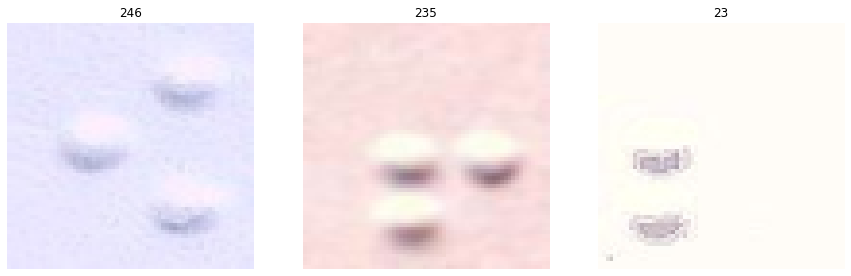

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(braille_cell_encoding_class[np.argmax(Y_train[i])])

## DenseNet121 Model

In [20]:
BATCH_SIZE = 64
EPOCHS = 50
SIZE = 64
N_ch = 3

In [21]:
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(64, activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

## Building DenseNet121

In [22]:
model = build_densenet()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 3)         84        
_________________________________________________________________
densenet121 (Functional)     (None, None, None, 1024)  7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               262400

In [23]:
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('./ModelCheckpointBalanced/densenet121.h5', verbose=2, save_best_only=True, monitor='val_loss')
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=2, mode='auto',
                              baseline=None, restore_best_weights=True)

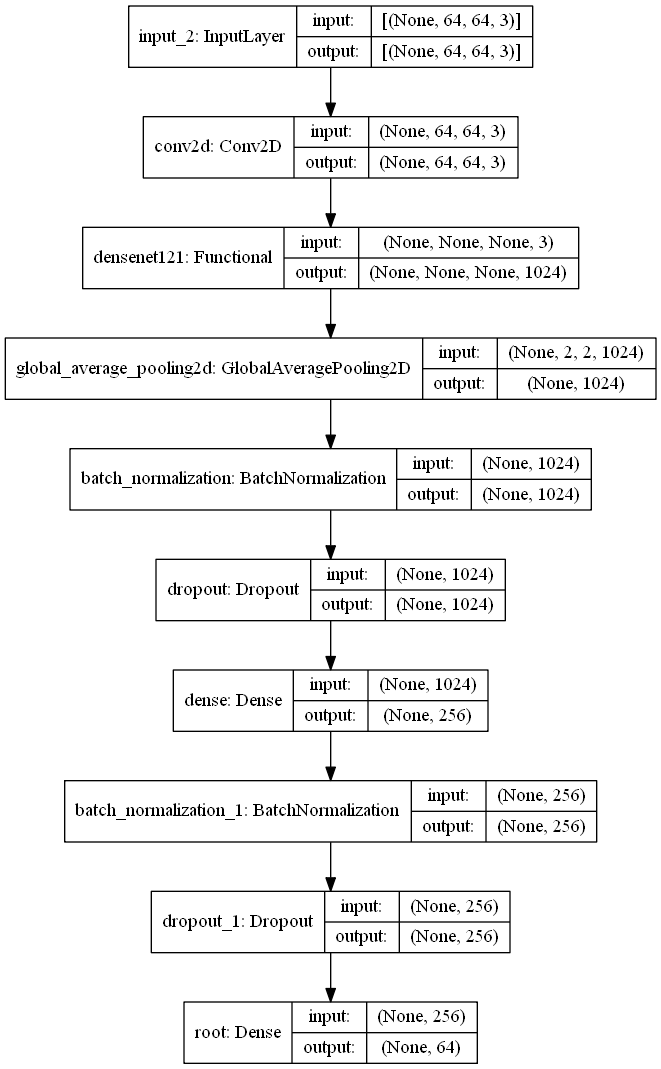

In [24]:
import pydot as pyd
from IPython.display import Image
from tensorflow.keras.utils import plot_model
# keras.utils.pydot = pyd
plot_model(model, to_file='./outputs/densenet121.png', show_shapes=True,show_layer_names=True)
Image(filename='./outputs/densenet121.png')

## Data Augmentation

In [25]:
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=10, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=False, # Randomly flip inputs horizontally
                        vertical_flip=False) # Randomly flip inputs vertically

## Model Fitting

In [26]:
datagen.fit(X_train)

In [27]:
# Fits the model on batches with real-time data augmentation
hist = model.fit(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=1,
               callbacks=[annealer, checkpoint, earlystopping],
               validation_data=(X_val, Y_val))

Epoch 1/50
600/600 [==============================] - 88s 115ms/step - loss: 3.9283 - accuracy: 0.1590 - val_loss: 1.7758 - val_accuracy: 0.6095

Epoch 00001: val_loss improved from inf to 1.77584, saving model to ./ModelCheckpointBalanced\densenet121.h5
Epoch 2/50
600/600 [==============================] - 68s 112ms/step - loss: 0.9832 - accuracy: 0.7411 - val_loss: 0.1814 - val_accuracy: 0.9507

Epoch 00002: val_loss improved from 1.77584 to 0.18143, saving model to ./ModelCheckpointBalanced\densenet121.h5
Epoch 3/50
600/600 [==============================] - 67s 112ms/step - loss: 0.3702 - accuracy: 0.9006 - val_loss: 0.3707 - val_accuracy: 0.8892

Epoch 00003: val_loss did not improve from 0.18143
Epoch 4/50
600/600 [==============================] - 68s 114ms/step - loss: 0.2615 - accuracy: 0.9285 - val_loss: 0.0512 - val_accuracy: 0.9791

Epoch 00004: val_loss improved from 0.18143 to 0.05117, saving model to ./ModelCheckpointBalanced\densenet121.h5
Epoch 5/50
600/600 [==========

In [28]:
# Save the entire model as a SavedModel.
model.save('./saved_models_balanced/densenet121_saved_model')

INFO:tensorflow:Assets written to: ./saved_models_balanced/densenet121_saved_model\assets


## Final Loss and Accuracy

In [29]:
model = load_model('./saved_models_balanced/densenet121_saved_model')
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

300/300 [==============================] - 10s 28ms/step - loss: 0.0080 - accuracy: 0.9979
Final Loss: 0.007967334240674973, Final Accuracy: 0.9979166388511658


## Confusion Matrix

In [30]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)

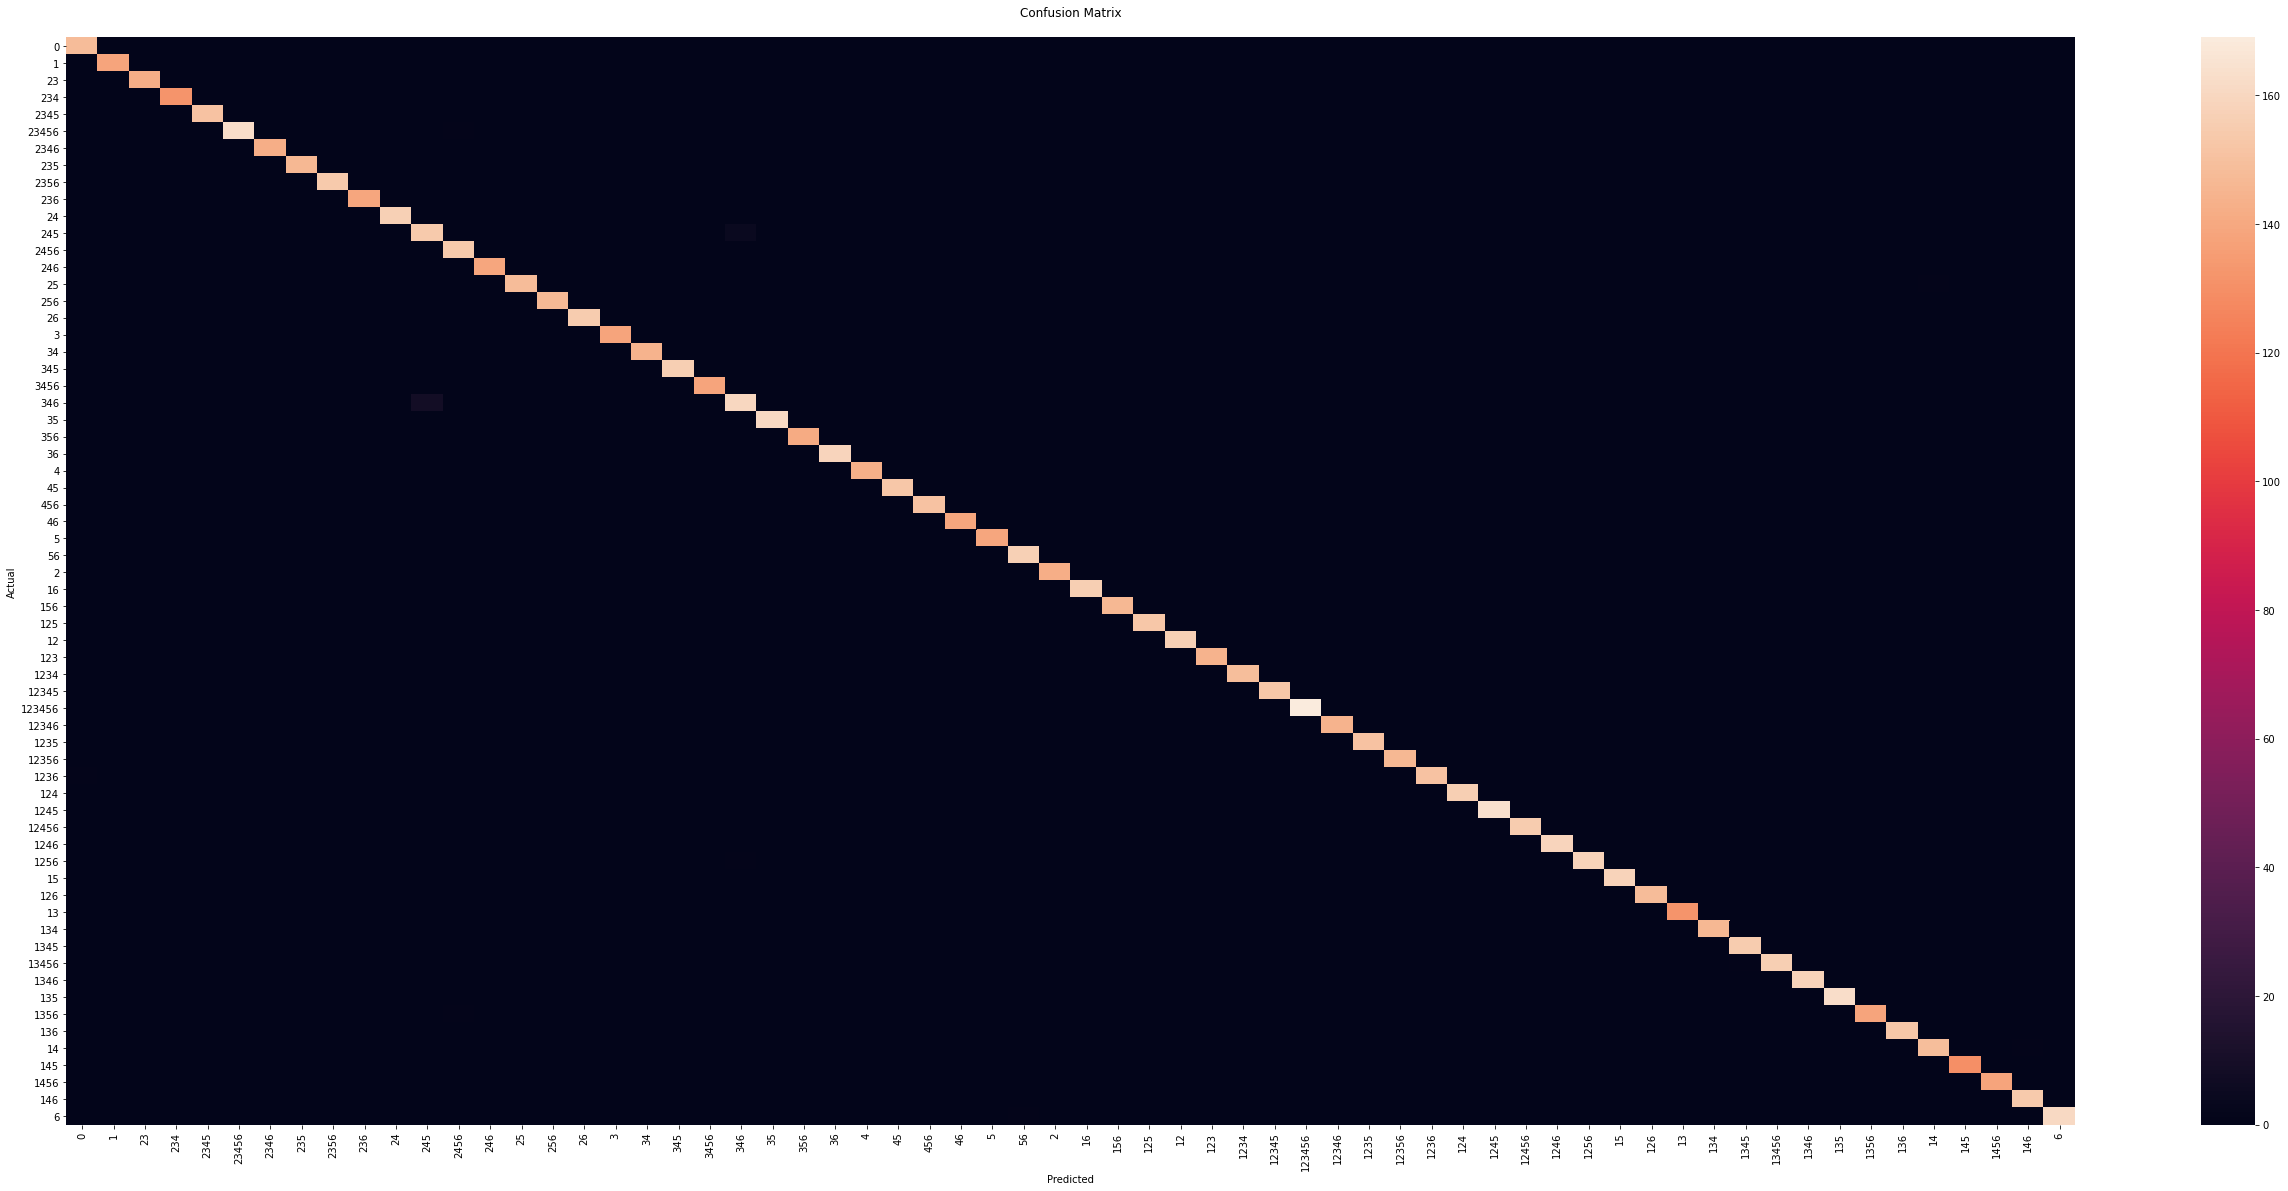

<Figure size 432x288 with 0 Axes>

In [31]:
import matplotlib.cm as clmap
plt.figure(figsize=(45, 20))
ax = sns.heatmap(cm, fmt='', xticklabels=braille_cell_encoding_class, yticklabels=braille_cell_encoding_class)
ax.set_title('Confusion Matrix\n');
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual');
plt.show()
plt.savefig('./outputs/densenet121_balanced_confusion_matrix.png')

## Classification Report

In [32]:
print(classification_report(Y_true, Y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       148
           1       1.00      1.00      1.00       138
           2       1.00      1.00      1.00       142
           3       1.00      1.00      1.00       132
           4       1.00      1.00      1.00       151
           5       1.00      0.99      1.00       164
           6       1.00      1.00      1.00       142
           7       1.00      1.00      1.00       146
           8       1.00      1.00      1.00       154
           9       1.00      1.00      1.00       139
          10       1.00      1.00      1.00       157
          11       0.95      0.97      0.96       158
          12       0.99      1.00      0.99       154
          13       1.00      1.00      1.00       139
          14       1.00      0.99      1.00       149
          15       1.00      1.00      1.00       147
          16       1.00      1.00      1.00       155
          17       1.00    

## Accuracy and Loss Curve

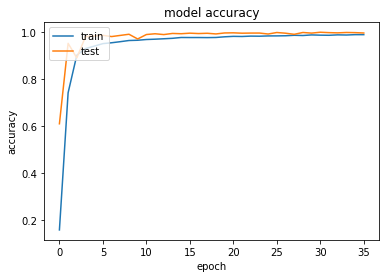

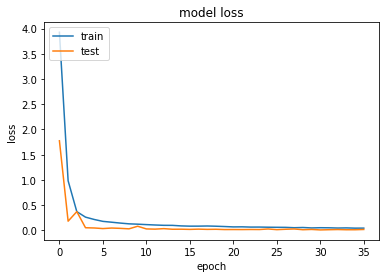

<Figure size 432x288 with 0 Axes>

In [33]:
# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('./outputs/densenet121_balanced_model_accuracy_plot.png')

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('./outputs/densenet121_balanced_model_loss_plot.png')

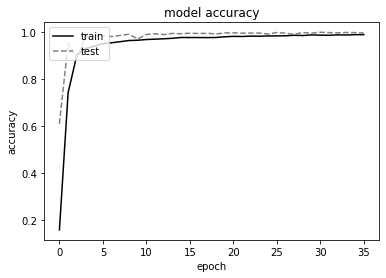

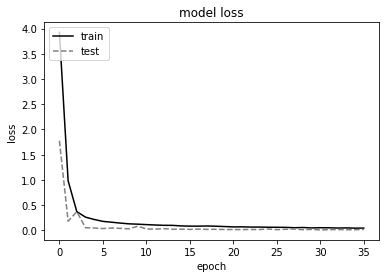

In [34]:
# accuracy plot 
plt.plot(hist.history['accuracy'], color='black')
plt.plot(hist.history['val_accuracy'], color='gray', linestyle='dashed')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'], color='black')
plt.plot(hist.history['val_loss'], color='gray', linestyle='dashed')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Prediction from Image

[3.13368764e-06 5.11004323e-08 3.58776724e-08 2.86289019e-08
 2.68540873e-07 2.08435977e-05 9.54796420e-08 1.41382941e-07
 2.02391007e-07 8.67577938e-08 4.34564740e-08 2.60099462e-08
 8.05713626e-07 1.09909394e-07 1.55188033e-07 2.88061614e-07
 3.14511546e-08 2.41636656e-07 7.29016350e-08 2.60981512e-08
 1.23292705e-06 9.36886408e-08 1.50245614e-06 6.15128641e-08
 6.01175259e-07 7.67004380e-08 1.10306523e-07 8.14479847e-07
 1.25539515e-07 1.27020655e-07 2.07808370e-07 1.27852600e-08
 1.32677471e-07 4.95509127e-08 1.13820953e-07 3.82537195e-07
 2.31132390e-06 3.23030736e-06 7.54777284e-05 9.99864221e-01
 1.00438410e-05 2.14998508e-07 4.59092962e-06 2.08794768e-06
 3.98782248e-07 2.28042694e-07 1.09638938e-06 2.77246613e-07
 2.67724886e-07 6.72805172e-08 7.07135200e-07 6.32096260e-08
 2.22792487e-08 2.09323705e-08 4.04151137e-07 1.56537993e-07
 1.75976655e-08 5.33019069e-08 6.06022965e-08 1.46997891e-07
 7.69746507e-08 5.76794207e-07 5.16871097e-08 8.02316890e-07]


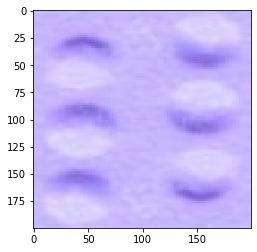

Prediction: 123456


In [35]:
from skimage import io
from tensorflow.keras.preprocessing import image

img_path = "./dataset/123456/123456-8-Uploaded-l.jpg"

img = image.load_img(img_path, grayscale=False, target_size=(64, 64))
show_img=image.load_img(img_path, grayscale=False, target_size=(200, 200))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',braille_cell_encoding_class[ind])

## Augments in modelling

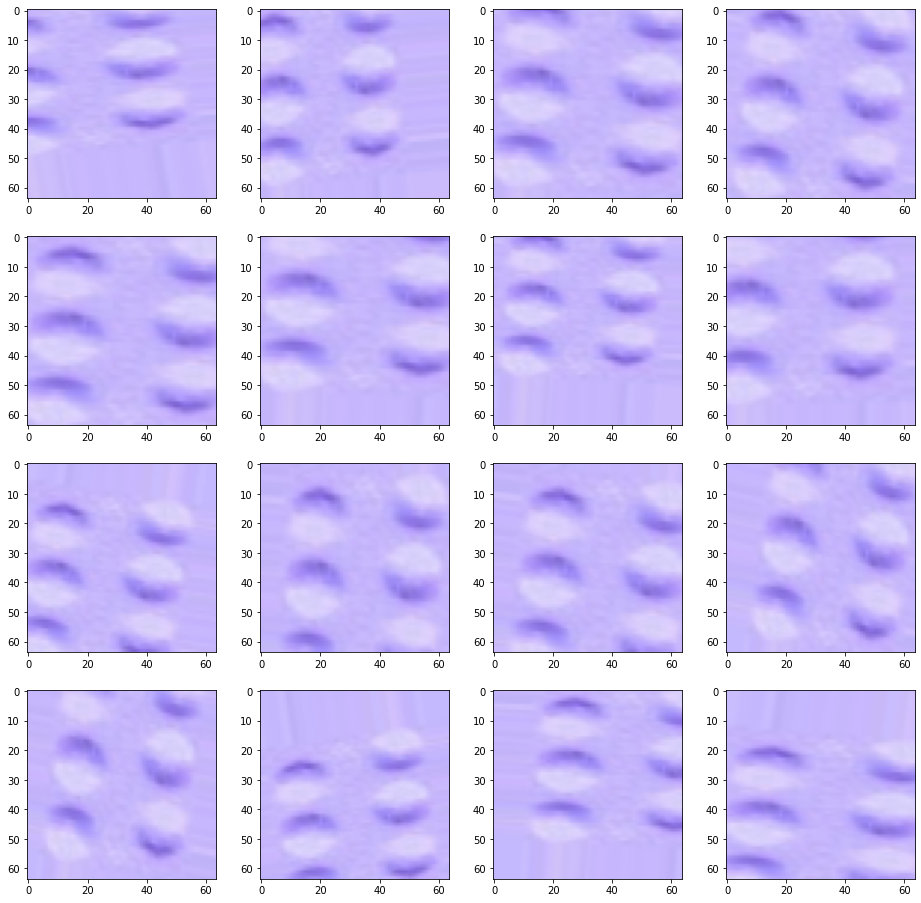

In [36]:
import tensorflow
img = tensorflow.keras.preprocessing.image.load_img(img_path, target_size= (64,64))
img_tensor = tensorflow.keras.preprocessing.image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

#Creates our batch of one image
pic = datagen.flow(img_tensor, batch_size =1)
plt.figure(figsize=(16, 16))
#Plots our figures
for i in range(1,17):
  plt.subplot(4, 4, i)
  batch = pic.next()
  image_ = batch[0].astype('uint8')
  plt.imshow(image_)
  
  
plt.show()